## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [17]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt


#### configuramos el `device` acorde al device disponible




In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
device

'cuda'

1. Cargar base de datos

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%cd /content/drive/MyDrive/EIA-UBA/Bimestre2/DL/Clase5

/content/drive/MyDrive/EIA-UBA/Bimestre2/DL/Clase5


In [22]:
#from google.colab import files
#files.upload()

In [23]:
import pickle
train = pickle.load(open("train.pkl", "rb" ))
train_label = pickle.load(open("train_label.pkl", "rb" ))
validation = pickle.load(open("val.pkl", "rb" ))
validation_label = pickle.load(open("val_label.pkl", "rb" ))
test = pickle.load(open("test.pkl", "rb" ))
test_label = pickle.load(open("test_label.pkl", "rb" ))

In [24]:
print('Tamaño set de train:', train.shape, '; Tamaño set de validacion:', validation.shape, '; Tamaño set de test:', test.shape)

Tamaño set de train: (56000, 28, 28) ; Tamaño set de validacion: (7000, 28, 28) ; Tamaño set de test: (7000, 28, 28)


In [25]:
train1 = np.expand_dims(train, axis=1)
validation1 = np.expand_dims(validation, axis=1)
test1 = np.expand_dims(test, axis=1)
print('Tamaño set de train:', train1.shape, '; Tamaño set de validacion:', validation1.shape, '; Tamaño set de test:', test1.shape)

Tamaño set de train: (56000, 1, 28, 28) ; Tamaño set de validacion: (7000, 1, 28, 28) ; Tamaño set de test: (7000, 1, 28, 28)


In [26]:
train1_n = torchvision.transforms.Normalize((0,), (255,))(torch.from_numpy(train1).float())
test1_n = torchvision.transforms.Normalize((0,), (255,))(torch.from_numpy(test1).float())

In [27]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(train1_n, torch.from_numpy(train_label)) #torch.from_numpy(train1).float()
test_dataset = TensorDataset(test1_n, torch.from_numpy(test_label)) #torch.from_numpy(test1).float()

In [28]:
type(train_dataset)

torch.utils.data.dataset.TensorDataset

In [29]:
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

## 2. Ver que la base de datos esté OK

In [30]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


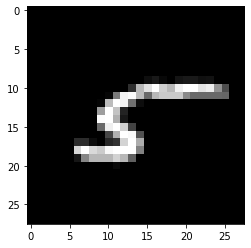

Label: 5


In [32]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[20]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

3. Construyo mi CNN

In [33]:
def get_output_sizes(H_in, W_in, p, d, k, s):
  H_out = (H_in+2*p-d*(k-1)-1)/s+1
  W_out = (W_in+2*p-d*(k-1)-1)/s+1
  print("Salida de get_output_sizes:", int(H_out), int(W_out))
  return int(H_out), int(W_out)

In [34]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                     # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [35]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    k = 3 #kernel size capa Conv2d
    s = 1 #stride capa Conv2D
    p = 1 #padding capa Conv2D
    d = 1 #dilation capa Conv2D
    pk = 3 #kernel size capa MaxPool2d
    ps = 2 #stride capa MaxPool2d
    pp = 1 #padding capa MaxPool2d
    pd = 1 #dilation capa MaxPool2d
    
    H_in1 = 28
    W_in1 = 28
    
    n_ch_out1 = 16
    H_out1_Conv2d, W_out1_Conv2d = get_output_sizes(H_in1, W_in1, p, d, k, s)
    H_out1, W_out1 = get_output_sizes(H_out1_Conv2d, W_out1_Conv2d, pp, pd, pk, ps) 
    print("Tamaño imagen a la salida de la capa 1:", H_out1, W_out1)
    self.conv1 = block(n_channels, n_ch_out1, k, p, s, pk, ps, pp)
    print("Tamaño imagen a la salida de la capa 1 (de block):", self.conv1(torch.randn(1, n_channels, int(H_in1), int(W_in1))).shape)
    self.conv1_out = None
    
    n_ch_out2 = 8
    H_out2_Conv2d, W_out2_Conv2d = get_output_sizes(H_out1, W_out1, p, d, k, s) 
    H_out2, W_out2 = get_output_sizes(H_out2_Conv2d, W_out2_Conv2d, pp, pd, pk, ps) 
    print("Tamaño imagen a la salida de la capa 2:", H_out2, W_out2)
    self.conv2 = block(n_ch_out1, n_ch_out2, k, p, s, pk, ps, pp)
    print("Tamaño imagen a la salida de la capa 2 (de block):", self.conv2(torch.randn(1, n_ch_out1, int(H_out1), int(W_out1))).shape)
    self.conv2_out = None

    n_ch_out3 = 8
    H_out3_Conv2d, W_out3_Conv2d = get_output_sizes(H_out2, W_out2, p, d, k, s) 
    H_out3, W_out3 = get_output_sizes(H_out3_Conv2d, W_out3_Conv2d, pp, pd, pk, ps) 
    print("Tamaño imagen a la salida de la capa 2:", H_out3, W_out3)
    self.conv3 = block(n_ch_out2, n_ch_out3, k, p, s, pk, ps, pp)
    print("Tamaño imagen a la salida de la capa 2 (de block):", self.conv3(torch.randn(1, n_ch_out2, int(H_out2), int(W_out2))).shape)
    self.conv3_out = None

    n_ch_out4 = 8
    H_out4_Conv2d, W_out4_Conv2d = get_output_sizes(H_out3, W_out3, p, d, k, s) 
    H_out4, W_out4 = get_output_sizes(H_out4_Conv2d, W_out4_Conv2d, pp, pd, pk, ps) 
    print("Tamaño imagen a la salida de la capa 2:", H_out4, W_out4)
    self.conv4 = block(n_ch_out3, n_ch_out4, k, p, s, pk, ps, pp)
    print("Tamaño imagen a la salida de la capa 2 (de block):", self.conv4(torch.randn(1, n_ch_out3, int(H_out3), int(W_out3))).shape)
    self.conv4_out = None

    self.fc = torch.nn.Linear(n_ch_out4*H_out4*W_out4, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def datos_CNN(self):
    i=0
    for layer in self.children():
        i=i+1
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    return i, pytorch_total_params


  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)
    x = self.sm(x)
    print("Tamaño salida sm: ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    y = self.sm(y)
    return y

In [36]:
model = CNN()

Salida de get_output_sizes: 28 28
Salida de get_output_sizes: 14 14
Tamaño imagen a la salida de la capa 1: 14 14
Tamaño imagen a la salida de la capa 1 (de block): torch.Size([1, 16, 14, 14])
Salida de get_output_sizes: 14 14
Salida de get_output_sizes: 7 7
Tamaño imagen a la salida de la capa 2: 7 7
Tamaño imagen a la salida de la capa 2 (de block): torch.Size([1, 8, 7, 7])
Salida de get_output_sizes: 7 7
Salida de get_output_sizes: 4 4
Tamaño imagen a la salida de la capa 2: 4 4
Tamaño imagen a la salida de la capa 2 (de block): torch.Size([1, 8, 4, 4])
Salida de get_output_sizes: 4 4
Salida de get_output_sizes: 2 2
Tamaño imagen a la salida de la capa 2: 2 2
Tamaño imagen a la salida de la capa 2 (de block): torch.Size([1, 8, 2, 2])
Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(

## 4. Veamos que las dimensiones sean consistentes.

In [37]:
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 16, 14, 14])
Tamaño salida conv2:  torch.Size([1, 8, 7, 7])
Tamaño salida conv3:  torch.Size([1, 8, 4, 4])
Tamaño salida conv4:  torch.Size([1, 8, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 32])
Tamaño salida fc (nro clases):  torch.Size([1, 10])
Tamaño salida sm:  torch.Size([1, 10])


## 5. Armo las funciones necesarias

In [38]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
      
    return np.mean(val_acc)
        

## 6. Entreno la red

In [39]:
n_epochs = 10 #50
test_acc = fit(model, dataloader, n_epochs)

val_loss 2.20563 val_acc 0.25161: 100%|██████████| 110/110 [00:00<00:00, 175.21it/s]


Epoch 1/10 loss 2.27514 val_loss 2.20563 acc 0.14977 val_acc 0.25161


val_loss 2.11507 val_acc 0.35043: 100%|██████████| 110/110 [00:00<00:00, 181.50it/s]


Epoch 2/10 loss 2.15892 val_loss 2.11507 acc 0.30064 val_acc 0.35043


val_loss 2.00617 val_acc 0.55885: 100%|██████████| 110/110 [00:00<00:00, 181.93it/s]


Epoch 3/10 loss 2.07087 val_loss 2.00617 acc 0.43712 val_acc 0.55885


val_loss 1.88612 val_acc 0.67836: 100%|██████████| 110/110 [00:00<00:00, 179.67it/s]


Epoch 4/10 loss 1.94567 val_loss 1.88612 acc 0.62941 val_acc 0.67836


val_loss 1.82332 val_acc 0.70488: 100%|██████████| 110/110 [00:00<00:00, 181.54it/s]


Epoch 5/10 loss 1.85550 val_loss 1.82332 acc 0.68911 val_acc 0.70488


val_loss 1.78744 val_acc 0.72135: 100%|██████████| 110/110 [00:00<00:00, 179.92it/s]


Epoch 6/10 loss 1.80922 val_loss 1.78744 acc 0.70786 val_acc 0.72135


val_loss 1.75764 val_acc 0.75133: 100%|██████████| 110/110 [00:00<00:00, 176.88it/s]


Epoch 7/10 loss 1.77806 val_loss 1.75764 acc 0.72373 val_acc 0.75133


val_loss 1.73031 val_acc 0.79015: 100%|██████████| 110/110 [00:00<00:00, 181.98it/s]


Epoch 8/10 loss 1.75027 val_loss 1.73031 acc 0.76123 val_acc 0.79015


val_loss 1.70496 val_acc 0.80904: 100%|██████████| 110/110 [00:00<00:00, 186.60it/s]


Epoch 9/10 loss 1.72513 val_loss 1.70496 acc 0.78848 val_acc 0.80904


val_loss 1.68196 val_acc 0.82116: 100%|██████████| 110/110 [00:00<00:00, 179.38it/s]

Epoch 10/10 loss 1.70242 val_loss 1.68196 acc 0.80296 val_acc 0.82116


## 7. Vemos que funcione.

torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


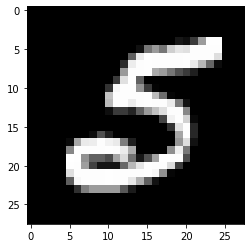

torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[3.3666e-02, 1.8337e-06, 2.6450e-01, 1.4420e-01, 6.7827e-04, 1.7210e-01,
         2.0020e-02, 1.6855e-04, 3.6340e-01, 1.2700e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
softmax de predicción:
tensor([[0.0928, 0.0898, 0.1169, 0.1037, 0.0898, 0.1066, 0.0916, 0.0898, 0.1291,
         0.0899]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
El numero es un:  8


In [40]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = np.random.randint(0, 63)

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))
# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print(samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat)
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1))
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

---
# Score final

In [41]:
n_layers, n_parameters = model.datos_CNN()
print("Número de parámetros:", n_parameters)
print("Número de epochs:", n_epochs)
print("Test accuracy:", test_acc)
print("Números de layers:", n_layers)

Número de parámetros: 2818
Número de epochs: 10
Test accuracy: 0.8211647727272727
Números de layers: 6


In [42]:
score = 1/np.log10(n_parameters)*10/n_epochs*test_acc*n_layers
print('Score obtenido:', score)

Score obtenido: 1.4281370760824168
